# Temperature calculation using relative quartz calibration and olivine absorption corrections

This is an example for the absorption correction to the radiance was done for Z Machine temperature measurements. This is for sample Z3327-S07.

Read ins

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import least_squares, curve_fit
from scipy import interpolate

sample information

In [3]:
qtz_d0 = 0.309 / 1000.0 # thickness of qtz in m
qtz_Us = 17.679 * 1000.0 # shock velocity in quartz in m/s
qtz_Us_err = 0.0556613 * 1000.0

samp_d0 = 0.640 / 1000.0 # thickness of olivine sample
samp_d0_err = 0.007 / 1000.0
samp_Us = 18.089 * 1000.0 #shock velocity in sample in m/s
samp_Us_err = 0.1642 * 1000.0
samp_up = 9.2982 * 1000.0 # particle velocity in sample in m/s
samp_up_err = 0.04848635 * 1000.0 

Olivine reflectivity calc

In [5]:
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import pylab as py
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import least_squares

def CalcRef(Us,Userr):
    
    params = [ 0.08181378, 31.03903275, 11.27009468, 19.73818428]
    cov = [[ 6.20252856e-07, -6.34795998e-05,  1.41691088e-05, -8.78600258e-06],
     [-6.34795998e-05,  4.39792426e-02, -3.24108427e-03,  4.23508328e-03],
     [ 1.41691088e-05, -3.24108427e-03,  5.53013078e-04, -4.35558199e-04],
     [-8.78600258e-06,  4.23508328e-03, -4.35558199e-04,  4.69743537e-04]]
    lmatR = sp.linalg.cholesky(cov,lower=True)

    def HillPower(Us,start,end,n,k):
        return start + ((end - start) * Us**n / (k**n + Us**n))
    
    steps = 1000000
    RHmc = np.ones(steps)
    Ref = np.ones(steps)
    Refe = np.ones(steps)
    for i in range(steps):    
        Usmc = Us + sp.randn()*Userr

        temp_mat=sp.randn(4,1)
        bmat=np.matmul(lmatR,temp_mat)    
        start_mc = params[0] + bmat[0,0]
        end_mc = params[1] + bmat[1,0]
        n_mc = params[2] + bmat[2,0]
        k_mc = params[3] + bmat[3,0]

        RH = HillPower(Usmc,start_mc,end_mc,n_mc,k_mc)
        RHmc[i] = RH
    Ref = np.median(RHmc)
    Refe = np.std(RHmc)
    
    
    return Ref, Refe

Quartz reflectivity and temperature calculation

In [6]:
import pylab as py
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

###
# Calculates Temperature of quartz From shock velocity measurement
#  Read in Quartz shock velocity.
# outputs quartz temperature, T  error, radiance, and R error.
#
# Simplified from "Sample_Temp" function

def Quartz_Temp(U,Ue):

    QR=np.loadtxt('Hicks_silica-data-summary.csv',delimiter=',',skiprows=0,usecols=[1]) #Percent
    QRE=np.loadtxt('Hicks_silica-data-summary.csv',delimiter=',',skiprows=0,usecols=[2]) #Percent
    QT=np.loadtxt('Hicks_silica-data-summary.csv',delimiter=',',skiprows=0,usecols=[5])
    QTE=np.loadtxt('Hicks_silica-data-summary.csv',delimiter=',',skiprows=0,usecols=[6])
    QU=np.loadtxt('Hicks_silica-data-summary.csv',delimiter=',',skiprows=0,usecols=[0])


    QR=QR/100
    QRE=QRE/100

    #blackbody=(1-wr).*((2*h.*(c.^2)./L.^5) .* (exp((h.*c)./(L.*k.*T1))-1).^(-1));
    steps=100000
    k = 1.38064852E-23 # Boltzmann constant J/T
    c = 299792458.0 # speed of light m/s
    h = 6.62607E-34 # Planck Constant
    L=520*10**-9 # Wavelength (nm)
    Qsize=np.size(QR)
    obs_T=np.zeros(steps)
    obs_Te=np.zeros(steps)
    obs_R=np.zeros(steps)
    obs_Re=np.zeros(steps)
    

    for j in range(steps): #Calculating radiance of all quartz
        U_temp=U+Ue*sp.randn()
        

        obs_T[j] = np.interp(U_temp,QU,QT) #observed
        obs_Te[j] = np.interp(U_temp,QU,QTE)
        obs_R[j] = np.interp(U_temp,QU,QR)
        obs_Re[j] = np.interp(U_temp,QU,QRE)
    T=np.mean(obs_T) #Temperature
    T_u=np.std(obs_T) # Temperature Error
    TE_mean=np.mean(obs_Te) # T error mean
    TE_u=np.std(obs_Te) # T error STD, needs to benon- linearly combined with T_u, TE_mean
    R=np.mean(obs_R)
    R_u=np.std(obs_R)
    RE_mean=np.mean(obs_Re)
    RE_u=np.std(obs_Re)

#    print(T,T_u,TE_mean,TE_u)
    
#    RE=((R_u)**2 + (RE_mean)**2 + (RE_u)**2)**(1/2)
#    TE=((T_u)**2 + (TE_mean)**2 + (TE_u)**2)**(1/2)
    RE=(R_u)+ (RE_mean)+ (RE_u)
    TE=(T_u) + (TE_mean) + (TE_u)
    #print(Qrad[1],Qrade[1])



    #print('Reflectivity', R, RE)
    #print('Temperature', T, TE)
    #Final=TE#np.std(temp)
    #print(np.mean(temp))
        
    
    return R, RE, T, TE
    


Read in data exported from SMASH. Includes luminosity, time and wavelength

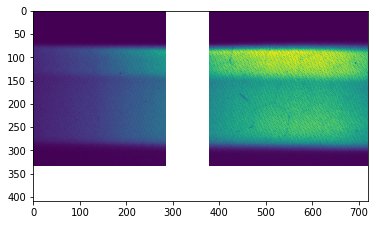

In [7]:
#data exported from SMASH
L = np.loadtxt('Z3327_data.txt',delimiter=',') #apparent luminosity 
time = np.loadtxt('Z3327_time.txt',delimiter=',') #time in ns
wavelength = np.loadtxt('Z3327_wavelength.txt',delimiter=',') #wavelength in nm

plt.imshow(L) #note, this is just the luminosity data, not mapped to time or wavelength.

Define constants

In [9]:
# Blackbody fit, 
# I = 2*h*c^2/L^5 * (exp(h*c/(L*k*T))-1)^(-1)Kwhere I is the intensity
# lam is wavelength
k = 1.38064852e-23 # Boltzmann constant m^2 kg/s K
c = 299792458.0 # speed of light m/s
h = 6.62607e-34 # Planck Constant m^2*kg/s
c1 = 2 * h * c**2 #just to keep things neat
c2 = h * c / k 

#Change these for each experiment
Ti= Quartz_Temp(qtz_Us/1000.0,qtz_Us_err/1000.0)[2] # Quartz T predicted from EOS (Erik's code)
Tie=Quartz_Temp(qtz_Us/1000.0,qtz_Us_err/1000.0)[3] # Qtz T error
wri=Quartz_Temp(qtz_Us/1000.0,qtz_Us_err/1000.0)[0]  # Qtz reflectivity predicted
wrie=Quartz_Temp(qtz_Us/1000.0,qtz_Us_err/1000.0)[1] # Qtz ref error


samp_R = CalcRef(samp_Us/1000.0,samp_Us_err/1000.0)[0]/100 # reflectivity of olivine predicted from fit to OMEGA data
samp_Re = CalcRef(samp_Us/1000.0,samp_Us_err/1000.0)[1]/100 # error

n2= 1.640 #olivine index of refraction
n1= 1.547 #qtz index of refraction
n3=1;

#Fresnel Reflectance on indices change as well. Normal Incidence
FR1=abs((n1 - n2) / (n1 + n2))**2
FR2=abs((n2 - n3) / (n2 + n3))**2

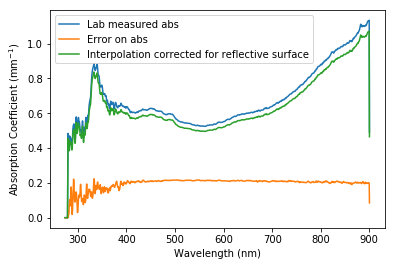

In [13]:
olabs = np.genfromtxt('silicate_absorption_2.csv',delimiter=',',skip_header=1) #olivine absorption

olabs_meter = olabs[:,0]*1e-9
olabs_abs = olabs[:,1]*1000  / (1+FR2)
olabs_abs_e = olabs[:,2]*1000

absint = sp.interpolate.interp1d(olabs_meter, olabs_abs)
absinterr = sp.interpolate.interp1d(olabs_meter, olabs_abs_e)


plt.plot(olabs[:,0],olabs[:,1],label='Lab measured abs')
plt.plot(olabs[:,0],olabs[:,2],label = 'Error on abs')
plt.plot(olabs[:,0],absint(olabs_meter)/1000,label="Interpolation corrected for reflective surface")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption Coefficient (mm$^{-1}$)')
plt.legend()

plt.show()


Visualize data and see where to cut

1
[ 9.17620212e+00  1.13233203e+01  1.10222485e+01  8.00001788e+00
  5.19648822e+00  4.19302818e+00  7.65107212e+00  7.88716545e+00
  1.86560455e+00  2.05954364e+00  1.00250939e+00  6.45444545e-01
  2.54887441e+00  6.12441394e+00  7.02291152e+00  7.01602879e+00
  7.12182576e+00  6.91489364e+00  6.18894673e+00  4.62730758e+00
 -1.20445758e-01  6.81186061e-01  4.37556970e+00  3.48344212e+00
  4.55505788e+00  9.35325545e+00  1.01423227e+01  4.39315455e+00
  4.80827121e+00  7.10686061e+00  4.57713848e+00  4.67530176e+00
  9.51030515e+00  9.99934967e+00  7.11020582e+00  8.22412424e+00
  1.18360424e+01  9.71947182e+00  8.84975879e+00  1.12245394e+01
  1.17932600e+01  1.13114464e+01  9.29528424e+00  9.01627273e+00
  9.00555830e+00  8.24829242e+00  7.68872242e+00  8.51040415e+00
  1.02231870e+01  1.11722018e+01  9.09299273e+00  6.99541364e+00
  5.11138226e+00  5.05258318e+00  8.01232364e+00  1.29902939e+01
  1.28216415e+01  1.63268785e+01  1.74953788e+01  2.01550606e+01
  2.63411939e+01  3.245

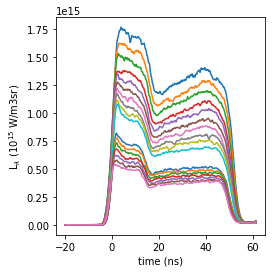

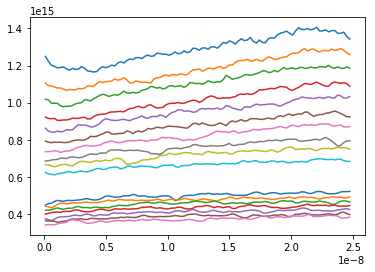

In [15]:
#Create bins of wavelength in 5 nm increments, skipping the region of the VISAR laser we clipped in SMASH
bins_a = np.arange(415,516,10)
bins_b = np.arange(550,626,10)
bins = np.append(bins_a,bins_b)

#some figs to see where to cut the data
fig, axes = plt.subplots(figsize=(3.75,4))
#axes.axvline(x=8)

#axes.axvline(x=11)
#axes.axvline(x=19)
#axes.axvline(x=40)

fig2,axes2 = plt.subplots()

for i in range(len(bins)):
    if i == 0 or i == 11:
        continue
    # Creating wavelength bins    
    lambda1 = bins[i-1]
    lambda2 = bins[i]

    # Array slicing adds 3rd dim to L, so we squeeze it out before avg
    # thing is the luminosity data averaged into wavelength bins
    thing = np.mean(L[:, np.where((lambda1 <= wavelength) & (wavelength < lambda2))].squeeze(), axis=1)
    window = np.mean(thing[np.where((time >= 8) & (time < 11))])
    lam = np.mean(wavelength[(lambda1 <= wavelength) & (wavelength < lambda2)]) * 1e-9
    print(i)
    print(thing)
    print(lam)
    
    #Calculate luminosity of quartz from estimated temperature
    Lqtz = (c1 / lam**5) / (np.exp(c2 / (lam * Ti)) - 1)

    #Average luminosity in quartz, varied by std dev
    win = (window) * (1 + FR1) * (1 + FR2) * np.exp((absint(lam) * samp_d0)) / (1-wri) # correct quartz for Fresnel reflections

    cor = win / Lqtz #correction factor
    cordat = (thing* (1 + FR2) / (1-samp_R)) / cor # correcting apparent radiance of all data

    axes.plot(time, cordat,label = lam*10**9) #plot of luminosity vs. time in each wavelength bin
    
    tnew = time * 1e-9 - qtz_d0/qtz_Us # reset time to start when the shock wave breaks out in olivine
    
    tnew_a = tnew[np.where((0 <= tnew) & (tnew <= 2.5e-8))] # clip off negative times
    sam = (thing[np.where((0 <= tnew) & (tnew <= 2.5e-8))] * (1 + FR2) / (1-samp_R))/cor # correct sample for Fresnel reflections
    ## Note - here we are using the shock reflectivity of olivine determined from OMEGA experiments. This is *not* wavelength dependent
    
    axes2.plot(tnew_a,sam)  #plot showing data to fit
      
axes.set_xlabel('time (ns)')
axes.set_ylabel('L$_{\lambda}$ (10$^{15}$ W/m3sr)')
plt.show()

Monte Carlo calculation of temperature

17446.361294346574 442.2097867972833
17800.95600414028 755.1368191073366


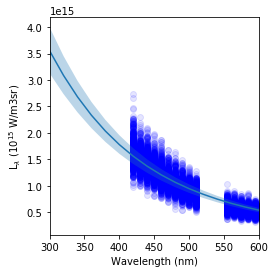

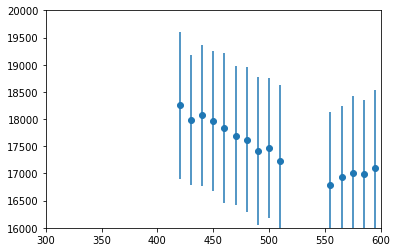

In [16]:
#Apparent luminosity fit from Luo 2004
def Lcalc(p,Lmeas,Us,up,x,d,aunshock):
        Lreal = p[0]
        ashock = p[1]
        return Lreal * (1 - np.exp(-ashock * (Us-up) * x))* np.exp(-aunshock * (d - Us * x)) - Lmeas
def Lfit(wavelength,T):
    return (1.191e-16 / wavelength**5) * (1.0/ (np.exp(1.439e-2/(wavelength*T))-1.0))

#steps for MC, 10000 takes a couple of hours on my computer
steps = 500

#Set up some arrays
Temp = np.ones((len(bins)-1,steps))
L_final = np.ones((len(bins)-1,steps))
lam_table = np.ones(len(bins)-1)
T_final = np.ones(steps)

fig, ax = plt.subplots(figsize=(3.75,4))

n2= 1.640 #olivine index of refraction
n2_e = 0.002
n1= 1.547 #qtz index of refraction
n1_e = 0.001
n3=1;


#This loop first bins the data, calculates the expected quartz luminosity within each wavelength bin, \\
#corrects the whole dataset relative to quartz, then calculates T of olivine in each bin
for j in range(steps):
    #Varying estimated quartz temperature (calculated using Erik Davie's code from the EOS of Hicks)
    qtzT = Ti + sp.randn()*Tie
    qtzR = wri + sp.randn()*wrie
    olR = samp_R + sp.randn()*samp_Re
    ol_d = samp_d0 + sp.randn()*samp_d0_err
    
    IOR2 = n2 + sp.randn()*n2_e
    IOR1 = n1 + sp.randn()*n1_e
    
    #Fresnel reflection correction with errors
    FR1=abs((IOR1 - IOR2) / (IOR1 + IOR2))**2
    FR2=abs((IOR2 - n3) / (IOR2 + n3))**2


    for i in range(len(bins)):
        #There are some bins with nans, so we skip them
        if i == 0 or i == 11:
            continue

        # Creating wavelength bins    
        lambda1 = bins[i-1]
        lambda2 = bins[i]

        # Array slicing adds 3rd dim to L, so we squeeze it out before avg
        # thing is the luminosity data averaged into wavelength bins
        thing = np.mean(L[:, np.where((lambda1 <= wavelength) & (wavelength < lambda2))].squeeze(), axis=1)

        #window is the quartz luminosity in each bin averaged over time to a single value
        window = np.mean(thing[np.where((time >= 8) & (time < 11))])

        window_e = np.std(thing[np.where((time >= 8) & (time < 11))]) #std dev of quartz luminosity

        lam = np.mean(wavelength[(lambda1 <= wavelength) & (wavelength < lambda2)]) * 1e-9 # unit correction to m
        lam_table[i-1] = lam
        
        #Calculate luminosity of quartz from estimated temperature
        Lqtz = (c1 / lam**5) / (np.exp(c2 / (lam * qtzT)) - 1)
        
        #Average luminosity in quartz, varied by std dev
        win = (window + sp.randn()*window_e) * (1 + FR1) * (1 + FR2) * np.exp((absint(lam)+sp.randn()*absinterr(lam)) * ol_d) / (1-qtzR) # correct quartz for Fresnel reflections

        cor = win / Lqtz #correction factor
        cordat = thing / cor # correcting apparent radiance of all data

        tnew = time * 1e-9 - qtz_d0/qtz_Us # reset time to start when the shock wave breaks out in olivine

        tnew_a = tnew[np.where((0 <= tnew) & (tnew <= 2.5e-8))] # clip off negative times
        sam = cordat[np.where((0 <= tnew) & (tnew <= 2.5e-8))] * (1 + FR2)/ (1-olR) # correct sample for Fresnel reflections
        ##Note, the reflectivity of the olivine shock is taken from OMEGA decaying shock experiments
        ##It is not wavelength dependent

        #least squares fit of radiance in quartz vs. time to the Luo equation
        temp = least_squares(Lcalc,(1e10,10),args = (sam,samp_Us,samp_up,tnew_a,samp_d0,absint(lam)))

        #results of the fit
        p = temp.x

        newL = p[0]
        a_s = p[1]/1000 #convert to mm-1
        
        #some of the fits result in negative absorption coefficients, skip those
        #if a_uns <0:
        #    continue

        #print(newL,a_s,a_uns)
        
        #T calculation from L(real)
        T = c2 / (lam * np.log((c1 / (lam**5 * newL)) + 1))
        Temp[i-1,j] = T
        
        ax.scatter(lam*1e9,newL,color = 'blue',alpha = 0.1)
        
        L_final[i-1,j] = newL
        
    Tfit,Tcov = curve_fit(Lfit,lam_table[:],L_final[:,j],p0=17000)
    
    T_final[j] = Tfit
    

#calculate temperatures within each wavelength bin and take the average
newT = np.mean(Temp,axis=1)
newT_err = np.std(Temp,axis=1)

newT_a = np.delete(newT,np.where(newT_err == 0))
newT_a_err = np.delete(newT_err,np.where(newT_err == 0))
lam_a = np.delete(lam_table,np.where(newT_err == 0))

aveT = np.mean(newT_a)
aveT_err = np.std(newT_a)
print(aveT,aveT_err)

plt.figure()
plt.errorbar(lam_a*1e9,newT_a,yerr=newT_a_err,fmt = ',', marker = 'o')
plt.xlim(300,600)
plt.ylim(16000,20000)

#calculate the average fitted temperature
T_final_real = np.mean(T_final)
T_final_err = np.std(T_final)
print(T_final_real,T_final_err)

PlankLam = np.arange(300e-9,700e-9,20e-9)


ax.plot(PlankLam*1e9,Lfit(PlankLam,T_final_real))
ax.fill_between(PlankLam*1e9,Lfit(PlankLam,T_final_real-T_final_err),Lfit(PlankLam,T_final_real+T_final_err),alpha=0.3)
ax.set_xlim(300,600)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('L$_{\lambda}$ (10$^{15}$ W/m3sr)')
plt.show()